In [13]:
import random as random
import numpy as np

## Creación del Ambiente

In [14]:
class Maze:
    def __init__(self, walls: dict, dimensions: tuple[int, int]):
        """
        Inicializa el laberinto
        
        Args:
            walls: Diccionario con estructura {(i,j): {'up': bool, 'down': bool, 'left': bool, 'right': bool}}
            dimensions: Tupla (nrows, ncols) con las dimensiones del laberinto
        """
        self.nrows, self.ncols = dimensions
        self.walls = walls
        self.initial_state = (6, 0)  # Punto rojo
        self.goal_state = (1, 6)     # Punto azul
        self.state = self.initial_state
    
    def get_current_state(self) -> tuple[int, int]:
        """Retorna el estado actual del agente"""
        return self.state
    
    def get_possible_actions(self, state: tuple[int, int]) -> list[str]:
        """
        Retorna TODAS las acciones posibles sin filtrar por paredes
        El agente puede intentar cualquier acción, pero recibirá penalización si choca
        """
        if self.is_terminal(state):
            return []
        return ['up', 'down', 'left', 'right']
    
    def _get_next_state(self, state: tuple[int, int], action: str) -> tuple[int, int]:
        """
        Calcula el estado siguiente según la acción (sin verificar si hay pared)
        """
        i, j = state
        if action == 'up':
            return (i - 1, j)
        elif action == 'down':
            return (i + 1, j)
        elif action == 'left':
            return (i, j - 1)
        elif action == 'right':
            return (i, j + 1)
        return state
    
    def _has_wall(self, state: tuple[int, int], direction: str) -> bool:
        """
        Verifica si hay pared en una dirección desde un estado
        """
        if state not in self.walls:
            return True  # Fuera de límites
        return self.walls[state][direction]
    
    def do_action(self, action: str) -> tuple[float, tuple[int, int]]:
        """
        Ejecuta la acción y retorna (recompensa, nuevo_estado)
        Modelo DETERMINISTA - la acción elegida se ejecuta tal cual
        """
        # Verificar si hay pared en la dirección deseada
        if self._has_wall(self.state, action):
            # Colisión con pared - el agente se queda en el mismo lugar
            reward = -5
            # self.state NO cambia
        else:
            # Movimiento exitoso - calcular nuevo estado
            next_state = self._get_next_state(self.state, action)
            self.state = next_state
            
            # Asignar recompensa
            if self.is_terminal(self.state):
                reward = 100
            else:
                reward = -1
        
        return reward, self.state
    
    def is_terminal(self, state: tuple[int, int] = None) -> bool:
        """Verifica si un estado es terminal (meta)"""
        if state is None:
            state = self.state
        return state == self.goal_state
    
    def reset(self):
        """Reinicia el ambiente al estado inicial"""
        self.state = self.initial_state

## Creacón del Sistema Q-Learning

In [15]:
class QLearning:
    def __init__(self, env: Maze, epsilon: float = 0.9, gamma: float = 0.9, alpha: float = 0.5):
        """
        Inicializa el algoritmo Q-Learning
        
        Args:
            env: Ambiente Maze
            epsilon: Probabilidad de exploración (decae con el tiempo)
            gamma: Factor de descuento
            alpha: Tasa de aprendizaje
        """
        self.env = env
        self.epsilon = epsilon
        self.gamma = gamma
        self.alpha = alpha
        self.qtable = {}
    
    def get_value(self, state: tuple[int, int], action: str) -> float:
        """Obtiene el valor Q(s,a) de la Q-table"""
        tupla = (state, action)
        
        if tupla not in self.qtable:
            self.qtable[tupla] = 0
        
        return self.qtable[tupla]
    
    def choose_action(self, state: tuple[int, int]) -> str:
        """
        Estrategia epsilon-greedy para elegir acción
        - Con probabilidad epsilon: explora (acción aleatoria)
        - Con probabilidad (1-epsilon): explota (mejor acción conocida)
        """
        possible_actions = self.env.get_possible_actions(state)
        
        if len(possible_actions) == 0:
            return None
        
        # Exploración vs Explotación
        if random.random() < self.epsilon:
            # EXPLORACIÓN: elegir acción aleatoria
            action = random.choice(possible_actions)
        else:
            # EXPLOTACIÓN: elegir mejor acción según Q-table
            values = [(action, self.get_value(state, action)) for action in possible_actions]
            values.sort(key=lambda x: x[1], reverse=True)
            action = values[0][0]
        
        return action
    
    def update_values(self, state: tuple[int, int], action: str, 
                     next_state: tuple[int, int], reward: float) -> None:
        """
        Actualiza la Q-table usando la ecuación de Q-Learning:
        Q(s,a) = (1-α)Q(s,a) + α[r + γ max_a' Q(s',a')]
        """
        current_q = self.get_value(state, action)
        
        possible_actions = self.env.get_possible_actions(next_state)
        
        if len(possible_actions) == 0:
            # Estado terminal - no hay acciones futuras
            max_next_q = 0
        else:
            # Encontrar el máximo Q-value del siguiente estado
            max_next_q = max(self.get_value(next_state, a) for a in possible_actions)
        
        # Ecuación de actualización de Q-Learning
        new_q = ((1 - self.alpha) * current_q) + (self.alpha * (reward + (self.gamma * max_next_q)))
        
        self.qtable[(state, action)] = new_q
    
    def best_action(self, state: tuple[int, int]) -> str:
        """
        Retorna la mejor acción para un estado según la Q-table
        (usado después del entrenamiento)
        """
        possible_actions = self.env.get_possible_actions(state)
        
        if len(possible_actions) == 0:
            return ""
        
        values = [self.get_value(state, action) for action in possible_actions]
        
        max_value = np.max(values)
        all_max_indices = np.where(np.array(values) == max_value)[0]
        
        chosen_index = random.choice(all_max_indices)
        chosen_action = possible_actions[chosen_index]
        return chosen_action
    
    def step(self, action: str) -> tuple[tuple[int, int], float, bool, str]:
        """
        Ejecuta un paso en el ambiente
        
        Returns:
            next_state: Estado siguiente
            reward: Recompensa recibida
            done: Si el episodio terminó
            info: Información adicional (string)
        """
        reward, next_state = self.env.do_action(action)
        done = self.env.is_terminal(next_state)
        info = f"Action: {action}, Reward: {reward}, Next state: {next_state}, Done: {done}"
        
        return (next_state, reward, done, info)
    
    def run(self, episodes: int) -> dict[tuple[int, str], float]:
        """
        Entrena el agente durante un número de episodios
        
        Args:
            episodes: Número de episodios de entrenamiento
            
        Returns:
            Q-table completa
        """
        for episode in range(episodes):
            self.env.reset()
            done = False
            steps = 0
            
            while not done:
                current_state = self.env.get_current_state()
                action = self.choose_action(current_state)
                
                if action is None:
                    break
                
                next_state, reward, done, info = self.step(action)
                self.update_values(current_state, action, next_state, reward)
                steps += 1
                
                # Límite de pasos para evitar bucles infinitos
                if steps > 1000:
                    break
            
            # Decaimiento de epsilon cada 100 episodios
            if (episode + 1) % 100 == 0:
                self.epsilon = max(0.01, self.epsilon - self.epsilon / 10)
                print(f"Episodio {episode + 1}/{episodes} - Epsilon: {self.epsilon:.3f} - Pasos: {steps}")
        
        return self.qtable
    
    def test_performance(self) -> tuple[dict, dict]:
        """
        Evalúa la política aprendida en todos los estados
        
        Returns:
            actions: Mejor acción para cada estado
            values: Mejor valor Q para cada estado
        """
        actions = {}
        values = {}
        
        for i in range(self.env.nrows):
            for j in range(self.env.ncols):
                state = (i, j)
                if not self.env.is_terminal(state):
                    action = self.best_action(state)
                    if action:
                        actions[state] = action
                        values[state] = self.get_value(state, action)
        
        return actions, values


## Definición del Ambiente (Walls)

In [30]:
walls = {
    (0,0): {'up': True, 'down': False, 'left': True, 'right': False},
    (0,1): {'up': True, 'down': False, 'left': False, 'right': True},
    (0,2): {'up': True, 'down': True, 'left': True, 'right': False},
    (0,3): {'up': True, 'down': False, 'left': False, 'right': True},
    (0,4): {'up': True, 'down': False, 'left': True, 'right': False},
    (0,5): {'up': True, 'down': True, 'left': False, 'right': False},
    (0,6): {'up': True, 'down': False, 'left': False, 'right': True},
    (1,0): {'up': False, 'down': False, 'left': True, 'right': True},
    (1,1): {'up': False, 'down': False, 'left': True, 'right': True},
    (1,2): {'up': True, 'down': False, 'left': True, 'right': False},
    (1,3): {'up': False, 'down': True, 'left': False, 'right': True},
    (1,4): {'up': False, 'down': False, 'left': True, 'right': False},
    (1,5): {'up': True, 'down': True, 'left': False, 'right': True},
    (1,6): {'up': False, 'down': False, 'left': True, 'right': False},
    (2,0): {'up': False, 'down': False, 'left': True, 'right': True},
    (2,1): {'up': False, 'down': False, 'left': True, 'right': True},
    (2,2): {'up': False, 'down': False, 'left': True, 'right': False},
    (2,3): {'up': True, 'down': False, 'left': False, 'right': True},
    (2,4): {'up': False, 'down': False, 'left': True, 'right': True},
    (2,5): {'up': True, 'down': False, 'left': True, 'right': False},
    (2,6): {'up': True, 'down': False, 'left': False, 'right': True},
    (3,0): {'up': False, 'down': False, 'left': True, 'right': True},
    (3,1): {'up': False, 'down': True, 'left': True, 'right': True},
    (3,2): {'up': False, 'down': False, 'left': True, 'right': False},
    (3,3): {'up': False, 'down': False, 'left': False, 'right': True},
    (3,4): {'up': False, 'down': True, 'left': True, 'right': False},
    (3,5): {'up': False, 'down': True, 'left': False, 'right': True},
    (3,6): {'up': False, 'down': False, 'left': True, 'right': True},
    (4,0): {'up': False, 'down': True, 'left': True, 'right': False},
    (4,1): {'up': True, 'down': True, 'left': False, 'right': False},
    (4,2): {'up': False, 'down': False, 'left': False, 'right': False},
    (4,3): {'up': False, 'down': False, 'left': False, 'right': False},
    (4,4): {'up': True, 'down': False, 'left': False, 'right': False},
    (4,5): {'up': True, 'down': False, 'left': False, 'right': True},
    (4,6): {'up': False, 'down': False, 'left': True, 'right': True},
    (5,0): {'up': True, 'down': False, 'left': True, 'right': False},
    (5,1): {'up': True, 'down': True, 'left': False, 'right': False},
    (5,2): {'up': False, 'down': True, 'left': False, 'right': True},
    (5,3): {'up': False, 'down': False, 'left': True, 'right': False},
    (5,4): {'up': False, 'down': True, 'left': False, 'right': False},
    (5,5): {'up': False, 'down': True, 'left': False, 'right': True},
    (5,6): {'up': False, 'down': False, 'left': True, 'right': True},
    (6,0): {'up': False, 'down': True, 'left': False, 'right': True},
    (6,1): {'up': True, 'down': False, 'left': True, 'right': False},
    (6,2): {'up': True, 'down': False, 'left': False, 'right': True},
    (6,3): {'up': False, 'down': False, 'left': True, 'right': False},
    (6,4): {'up': True, 'down': False, 'left': False, 'right': True},
    (6,5): {'up': True, 'down': False, 'left': True, 'right': False},
    (6,6): {'up': False, 'down': False, 'left': False, 'right': True},
    (7,0): {'up': True, 'down': True, 'left': True, 'right': False},
    (7,1): {'up': False, 'down': True, 'left': False, 'right': True},
    (7,2): {'up': False, 'down': True, 'left': True, 'right': False},
    (7,3): {'up': False, 'down': True, 'left': False, 'right': True},
    (7,4): {'up': False, 'down': True, 'left': True, 'right': False},
    (7,5): {'up': False, 'down': True, 'left': False, 'right': False},
    (7,6): {'up': False, 'down': True, 'left': True, 'right': True},
}

## Evaluación

ENTRENAMIENTO DEL AGENTE
Estado inicial: (6, 0)
Estado meta: (1, 6)
Dimensiones: 8x7

Episodio 100/1000 - Epsilon: 0.810 - Pasos: 1001
Episodio 200/1000 - Epsilon: 0.729 - Pasos: 90
Episodio 300/1000 - Epsilon: 0.656 - Pasos: 1001
Episodio 400/1000 - Epsilon: 0.590 - Pasos: 86
Episodio 500/1000 - Epsilon: 0.531 - Pasos: 1001
Episodio 600/1000 - Epsilon: 0.478 - Pasos: 62
Episodio 700/1000 - Epsilon: 0.430 - Pasos: 1001
Episodio 800/1000 - Epsilon: 0.387 - Pasos: 31
Episodio 900/1000 - Epsilon: 0.349 - Pasos: 47
Episodio 1000/1000 - Epsilon: 0.314 - Pasos: 39

EVALUACIÓN DE LA POLÍTICA APRENDIDA

Acciones aprendidas (algunos estados):
  Estado (6, 0): up (Q-value: -1.23)
  Estado (5, 0): right (Q-value: -0.25)
  Estado (4, 0): right (Q-value: 0.83)
  Estado (3, 0): down (Q-value: -0.25)
  Estado (2, 0): down (Q-value: -1.23)
  Estado (1, 0): down (Q-value: -2.36)
  Estado (1, 1): down (Q-value: -8.54)
  Estado (1, 2): down (Q-value: -0.25)
  Estado (1, 3): left (Q-value: -1.26)
  Estado

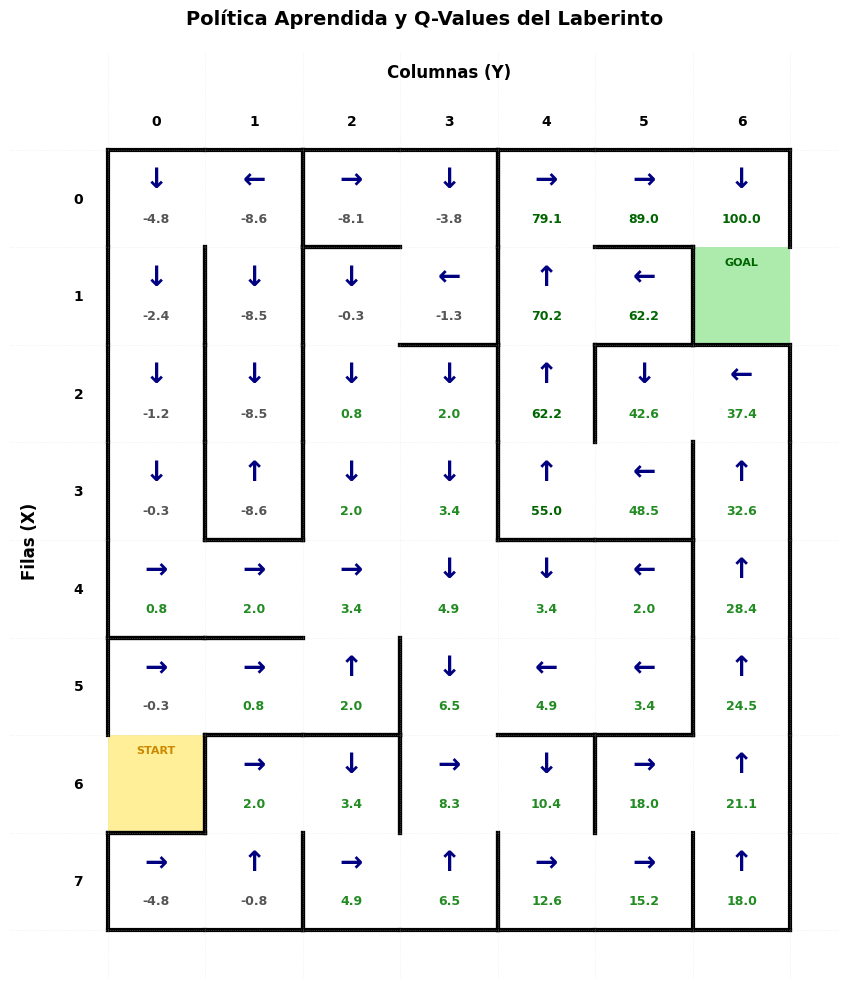

In [33]:
maze = Maze(walls, (8, 7))
    
# Crear el agente Q-Learning
agent = QLearning(maze, epsilon=0.9, gamma=0.9, alpha=0.5)
    
print("="*60)
print("ENTRENAMIENTO DEL AGENTE")
print("="*60)
print(f"Estado inicial: {maze.initial_state}")
print(f"Estado meta: {maze.goal_state}")
print(f"Dimensiones: {maze.nrows}x{maze.ncols}")
print()
    
# Entrenar el agente
qtable = agent.run(episodes=1000)
    
print()
print("="*60)
print("EVALUACIÓN DE LA POLÍTICA APRENDIDA")
print("="*60)
    
# Evaluar la política aprendida
actions, values = agent.test_performance()
    
# Mostrar algunas acciones aprendidas
print("\nAcciones aprendidas (algunos estados):")
for state in [(6,0), (5,0), (4,0), (3,0), (2,0), (1,0), (1,1), (1,2), (1,3), (1,4), (1,5), (1,6)]:
    if state in actions:
        print(f"  Estado {state}: {actions[state]} (Q-value: {values[state]:.2f})")
    
print(f"\nNúmero total de entradas en Q-table: {len(qtable)}")
print(f"Número de estados con política definida: {len(actions)}")
    
print()
print("="*60)
print("VISUALIZACIÓN DEL LABERINTO")
print("="*60)
    
# Visualizar el laberinto con la política aprendida
plot_maze_policy(maze, actions, values)